# Config

In [1]:
seed_value= 42

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

In [2]:
import os

os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, losses
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from livelossplot.inputs.tf_keras import PlotLossesCallback

# Initialization

In [4]:
num_epochs  = 100
batch_size  = 2
cls_num     = 2
shape       = (40, 200, 150, 1)
lr          = 0.0001
wd          = 1e-5
opt         = optimizers.Adamax(learning_rate=lr) # Adamax / SGD, 
los         = losses.CategoricalCrossentropy()
mtr         = 'accuracy'

AUTO = tf.data.AUTOTUNE
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (shape[0] // PATCH_SIZE[0]) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [5]:
address         = 'videos lts/videos lts/'
files           = os.listdir(address)

l = len(files)
random.Random(seed_value).shuffle(files)

X_train = files[:int(0.8 * l)]
X_test = files[int(0.8 * l):int(0.9 * l)]
X_val = files[int(0.9 * l):]

steps_per_train = len(X_train) // batch_size
steps_per_test  = len(X_test) // batch_size
steps_per_val   = len(X_val) // batch_size

# Data generator

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, shape, batch_size, cls_num):
        self.data       = data
        self.shape      = shape
        self.batch_size = batch_size
        self.cls_num    = cls_num

        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))


    def __getitem__(self, index):
        indexes       = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.data[k] for k in indexes]
        x, y          = self.__data_generation(list_IDs_temp)
        return x, y


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))


    def __data_generation(self, list_IDs_temp):
        x = np.empty((self.batch_size, int(self.shape[0]), int(self.shape[1]), int(self.shape[2]), int(self.shape[3])))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(list_IDs_temp):
            y[i]  = int(ID[-3])
            for img in range(int(self.shape[0])):
                my_img = image.img_to_array(image.load_img('videos lts/videos lts/' + ID + '/' + str(img) + '.jpg', color_mode='grayscale', target_size=(int(self.shape[1]), int(self.shape[2]))))
                my_img /= 255.0
                x[i, img, :, :, :] = my_img

        return x, to_categorical(y, num_classes=self.cls_num)


train_gen = DataGenerator(X_train, shape, batch_size, cls_num)
test_gen  = DataGenerator(X_test , shape, batch_size, cls_num)
val_gen   = DataGenerator(X_val  , shape, batch_size, cls_num)

# Model

In [7]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches
    
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [8]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=shape,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=cls_num,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
def get_model():

  model = create_vivit_classifier(tubelet_embedder=TubeletEmbedding(embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE),
                                  positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM))

  return model

model = get_model()
model.compile(optimizer=opt, loss=los, metrics=mtr)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 200, 15  0           []                               
                                0, 1)]                                                            
                                                                                                  
 tubelet_embedding (TubeletEmbe  (None, 2250, 128)   65664       ['input_1[0][0]']                
 dding)                                                                                           
                                                                                                  
 positional_encoder (Positional  (None, 2250, 128)   288000      ['tubelet_embedding[0][0]']      
 Encoder)                                                                                     

# Train

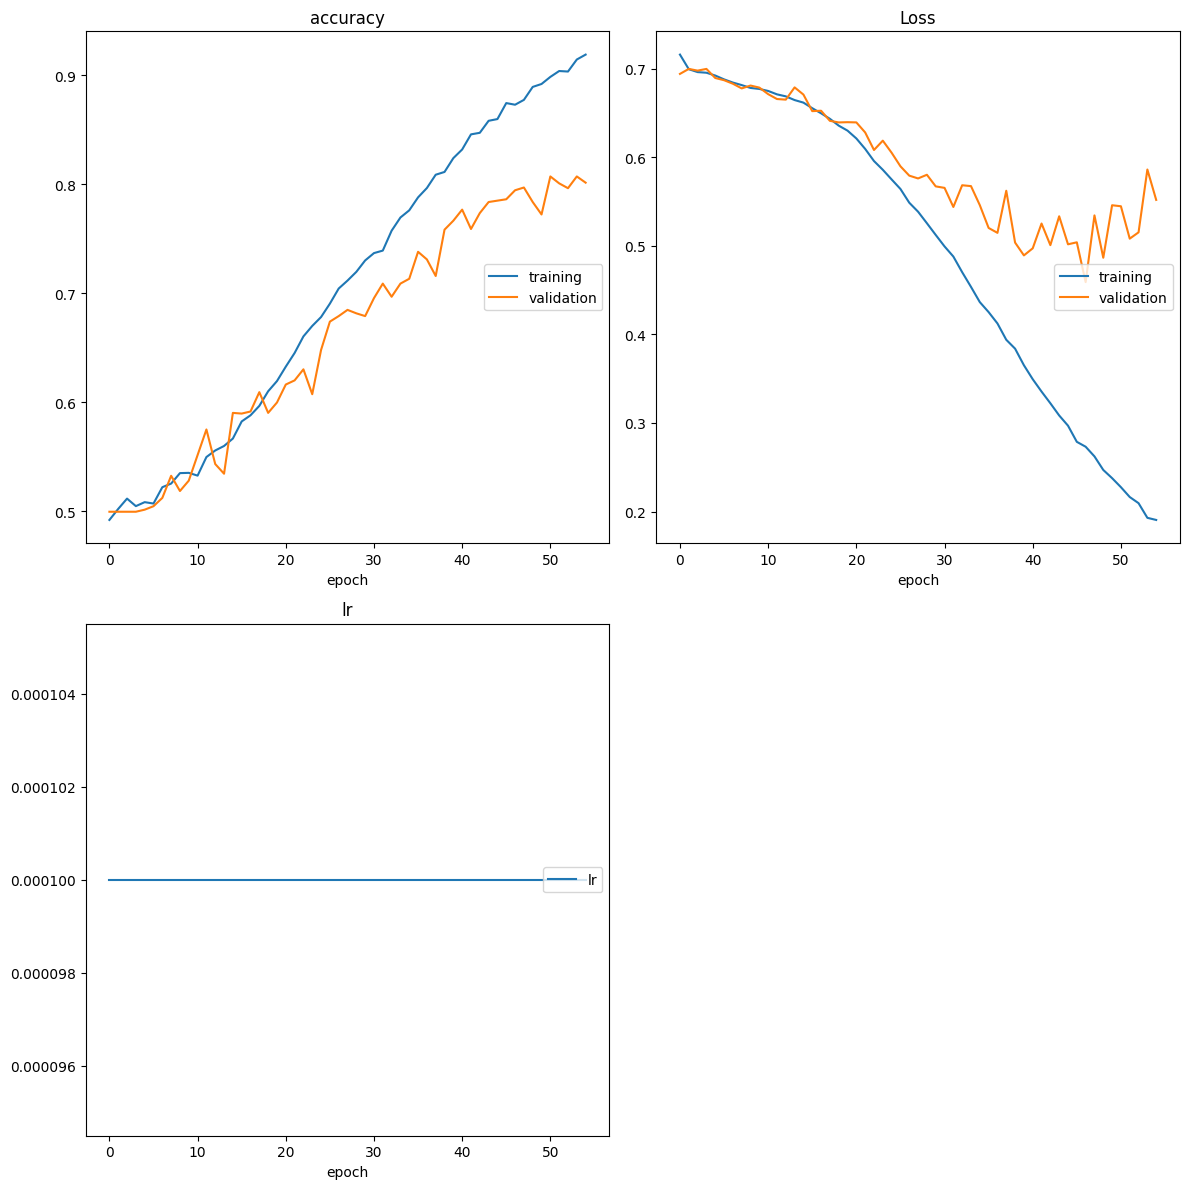

accuracy
	training         	 (min:    0.492, max:    0.919, cur:    0.919)
	validation       	 (min:    0.499, max:    0.807, cur:    0.801)
Loss
	training         	 (min:    0.190, max:    0.716, cur:    0.190)
	validation       	 (min:    0.459, max:    0.700, cur:    0.552)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
6304/6304 [==============================] - 2446s 388ms/step - loss: 0.1905 - accuracy: 0.9189 - val_loss: 0.5519 - val_accuracy: 0.8014 - lr: 1.0000e-04
Epoch 55: early stopping


In [10]:
def callback():
  mymonitor = 'val_loss'
  mymode    = 'min'

  main_chk  = ModelCheckpoint(filepath='my_checkpoint1', monitor=mymonitor, mode=mymode, verbose=1, save_best_only=True)
  early_st  = EarlyStopping(monitor=mymonitor, mode=mymode, patience=10, verbose=1)
  rduce_lr  = ReduceLROnPlateau(monitor=mymonitor, mode=mymode, factor=0.5, patience=5, verbose=1, min_lr=0.0001)
  tr_plot   = PlotLossesCallback()

  return [main_chk, rduce_lr, tr_plot, early_st]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=callback(),
                    steps_per_epoch  = steps_per_train,
                    validation_steps = steps_per_val)

# Evaluation

In [12]:
testmodel = load_model('my_checkpoint1', compile=True)
tst_loss , tst_acc = testmodel.evaluate(test_gen, steps = steps_per_test)

788/788 [==============================] - 77s 97ms/step - loss: 0.5137 - accuracy: 0.7805
